In [2]:
#!ls ~/trained_models/
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

In [3]:
from itertools import chain
from pathlib import Path
from datatype_recovery.models.dataset import load_dataset_from_path, max_typesequence_len_in_dataset
from datatype_recovery.models.dataset.encoding import *

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from tqdm import tqdm

from datatype_recovery.models.metrics import acc_heuristic_numcorrect

def eval_model_on_dataset(model_path:Path, device:str, dataset_path:Path) -> float:
    '''
    Evaluates the model on the given dataset and returns the accuracy of the corrected
    model output against the dataset labels
    '''
    dataset = load_dataset_from_path(dataset_path)
    include_comp = not dataset.drop_component
    max_true_seq_len = max_typesequence_len_in_dataset(dataset_path)
    return eval_model_on_subset(model_path, device, dataset, max_true_seq_len, include_comp)

def eval_model_on_subset(model_path:Path, device:str, dataset, max_true_seq_len:int, include_comp:bool) -> float:
    '''
    Evaluates the model on the given subset and returns the accuracy of the corrected
    model output against the dataset labels
    '''
    model = torch.load(model_path)
    print(model)

    # take the max of model seq length and max seq length of dataset so we
    # calculate accuracy correctly (without truncating something)
    max_len = max(model.max_seq_len, max_true_seq_len)

    # prepare the data loaders
    batch_size = 64
    dataset.transform = T.Compose([ToBatchTensors(), ToFixedLengthTypeSeq(max_len)])

    # split the dataset into the part divisible by batch size and the leftovers
    # we can chain these together for performance - our metrics simply iterate
    # through all elements in the batch
    batched_total = len(dataset)-(len(dataset)%batch_size)
    batch_loader = DataLoader(dataset[:batched_total], batch_size=batch_size)
    leftovers_loader = DataLoader(dataset[batched_total:], batch_size=1)

    print(f'Running eval...')

    model.to(device)
    model.eval()
    num_correct = 0

    for data in tqdm(chain(batch_loader, leftovers_loader), total=len(batch_loader)+len(leftovers_loader)):
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        num_correct += acc_heuristic_numcorrect(data.y, out, include_comp)

    accuracy = num_correct/len(dataset)
    print(f'Accuracy = {accuracy*100:,.2f}%')

    return accuracy

In [4]:
# TODO: eval on an interesting subset of the data
# from torch.utils.data import Subset
# Subset()

In [5]:
# dataset_path = Path.home()/'datasets/test_ds'
# dataset_path = Path.home()/'datasets/trainset_astera_full_5hops_nocomp'

# dataset_path = Path.home()/'datasets/coreutils_5hops'
dataset_path = Path.home()/'datasets/coreutils_full_5hops'

# model_path = Path.home()/'trained_models/RERUN_structural_3out_4hops_nocomp.pt'
# model_path = Path.home()/'trained_models/withedges_4out_4hops_nocomp.pt'
# model_path = Path.home()/'trained_models/dragon_4out_5hops_coreutils__COPY.pt'

# model_path = Path.home()/'trained_models/dragon_5hops_ffmpeg__COPY.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_ffmpeg_balanced__EPOCH42.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_256ch_balanced.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_32ch_balanced.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_64ch_balanced.pt'
model_path = Path.home()/'trained_models/dragon_5hops_5heads_3linear/dragon_5hops_5heads_3linear_ep50.pt'

# eval_model_on_dataset(model_path, 'cuda:3', dataset_path)

In [6]:
dataset = load_dataset_from_path(dataset_path)
from datatype_recovery.models.dataset import InMemTypeSequenceDataset

df = dataset.read_vars_csv()
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip
0,1056281,"37,78,82,107,111",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,NaN,-168.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
1,1056439,"37,94,114",local_b8,timeval,stack,NaN,-184.0,STRUCT,STRUCT,real_end,...,NaN,-184.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
2,1056439,"57,160,180,226,246",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,NaN,-168.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
3,1056881,"300,300,300",auVar1,uchar[16],unique,NaN,243584.0,ARR,"ARR,uchar",auVar2,...,NaN,243584.0,ARR,"ARR,uchar",False,"{""kind"": ""ArrayT...",1000,l,False,False
4,1056881,"145,485",iVar2,int32,register,eax,0.0,BUILTIN,int32,iVar3,...,eax,0.0,BUILTIN,int32,False,"{""kind"": ""Builti...",1000,l,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85154,1092028,-1,NaN,uint32,NaN,NaN,NaN,BUILTIN,uint32,NaN,...,NaN,NaN,BUILTIN,char,True,"{""kind"": ""Builti...",1116,p,True,True
85155,1092192,-1,NaN,char*,NaN,NaN,NaN,PTR,"PTR,char",NaN,...,NaN,NaN,PTR,"PTR,char",True,"{""kind"": ""Pointe...",1116,p,True,True
85156,1092232,-1,NaN,uint64,NaN,NaN,NaN,BUILTIN,uint64,NaN,...,NaN,NaN,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,True,True
85157,1092416,-1,NaN,void,NaN,NaN,NaN,BUILTIN,void,NaN,...,NaN,NaN,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,True,True


In [7]:
from datatype_recovery.models.dataset.encoding import TypeSequence

def make_predictions_on_dataset(model_path:Path, device:str, dataset, max_true_seq_len:int) -> pd.DataFrame:
    '''
    Evaluates the model on the given dataset and returns a DataFrame containing the varid columns
    of each variable in the dataset along with its predicted type sequence (raw and corrected)
    '''
    model = torch.load(model_path)
    print(model)

    # take the max of model seq length and max seq length of dataset so we
    # calculate accuracy correctly (without truncating something)
    max_len = max(model.max_seq_len, max_true_seq_len)

    # prepare the data loaders
    batch_size = 512
    dataset.transform = T.Compose([ToBatchTensors(), ToFixedLengthTypeSeq(max_len, dataset.include_component)])

    # split the dataset into the part divisible by batch size and the leftovers
    # we can chain these together for performance - our metrics simply iterate
    # through all elements in the batch
    batched_total = len(dataset)-(len(dataset)%batch_size)
    batch_loader = DataLoader(dataset[:batched_total], batch_size=batch_size)
    leftovers_loader = DataLoader(dataset[batched_total:], batch_size=1)

    print(f'Running eval...')

    model.to(device)
    model.eval()

    model_outputs = []

    tseq = TypeSequence(dataset.include_component)

    for data in tqdm(chain(batch_loader, leftovers_loader), total=len(batch_loader)+len(leftovers_loader)):
        data.to(device)
        edge_attr = data.edge_attr if model.uses_edge_features else None
        out = model(data.x, data.edge_index, data.batch, edge_attr=edge_attr)

        for i, pred in enumerate(out):
            raw = tseq.decode(pred, drop_empty_elems=True)
            corrected = tseq.decode(pred, force_valid_seq=True)

            binid, funcstart, sig, vartype = data.varid[i]

            model_outputs.append((
                binid, funcstart, sig, vartype,
                ','.join(raw),
                ','.join(corrected),
            ))

    return pd.DataFrame.from_records(model_outputs, columns=['BinaryId','FunctionStart','Signature','Vartype','RawPred','Pred'])

In [8]:
max_true_len = df.TypeSeq_Debug.apply(lambda ts: len(ts.split(','))).max()
model_pred = make_predictions_on_dataset(model_path, 'cpu', dataset, max_true_len)
model_pred

DragonModel(
  (gat_layers): ModuleList(
    (0): GATConv(133, 128, heads=5)
    (1-4): 4 x GATConv(640, 128, heads=5)
  )
  (pred_head): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(128, 92, bias=True)
  )
)
Running eval...


100%|██████████| 251/251 [01:08<00:00,  3.69it/s]


,BinaryId,FunctionStart,Signature,Vartype,RawPred,Pred
0,1000,1056281,"37,78,82,107,111",l,STRUCT,STRUCT
1,1000,1056281,"78,82,107,111,130",p,"PTR,STRUCT","PTR,STRUCT"
2,1000,1056439,"37,94,114",l,STRUCT,STRUCT
3,1000,1056439,"57,160,180,226,246",l,STRUCT,STRUCT
4,1000,1056439,"91,124,138,156,1...",p,"PTR,uint64","PTR,uint64"
...,...,...,...,...,...,...
52879,1116,1092232,"72,85,95",l,uint64,uint64
52880,1116,1092232,28,p,int32,int32
52881,1116,1092232,"55,113,154,171",p,"PTR,uchar","PTR,uchar"
52882,1116,1092232,"44,85,125,136,163",p,uint64,uint64


In [9]:
mdf = df.merge(model_pred, how='right', on=['BinaryId','FunctionStart','Signature','Vartype'])
mdf

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,RawPred,Pred
0,1056281,"37,78,82,107,111",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,STRUCT,STRUCT
1,1056281,"78,82,107,111,130",param_1,timeval*,register,rdi,56.0,PTR,"PTR,STRUCT",ts,...,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",1000,p,False,False,"PTR,STRUCT","PTR,STRUCT"
2,1056439,"37,94,114",local_b8,timeval,stack,NaN,-184.0,STRUCT,STRUCT,real_end,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,STRUCT,STRUCT
3,1056439,"57,160,180,226,246",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,STRUCT,STRUCT
4,1056439,"91,124,138,156,1...",param_1,int64*,register,rdi,56.0,PTR,"PTR,int64",ts,...,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",1000,p,False,False,"PTR,uint64","PTR,uint64"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52879,1092232,"72,85,95",sVar2,uint64,register,rax,0.0,BUILTIN,uint64,sVar2,...,BUILTIN,uint64,False,"{""kind"": ""Builti...",1116,l,False,False,uint64,uint64
52880,1092232,28,param_1,uint32,register,edi,56.0,BUILTIN,uint32,category,...,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,False,False,int32,int32
52881,1092232,"55,113,154,171",param_2,uchar*,register,rsi,48.0,PTR,"PTR,uchar",buf,...,PTR,"PTR,char",True,"{""kind"": ""Pointe...",1116,p,False,False,"PTR,uchar","PTR,uchar"
52882,1092232,"44,85,125,136,163",param_3,uint64,register,rdx,16.0,BUILTIN,uint64,bufsize,...,BUILTIN,uint64,True,"{""kind"": ""Builti...",1116,p,False,False,uint64,uint64


In [10]:
# compute accuracy for levels 1-3 (first type element only, first two elements, etc...)
for i in range(4):
    mdf[f'TypeSeqL{i+1}_Debug'] = mdf.TypeSeq_Debug.apply(lambda x: ",".join(x.split(',')[:i+1]))
    mdf[f'PredL{i+1}'] = mdf.Pred.apply(lambda x: ",".join(x.split(',')[:i+1]))

In [11]:
acc_corrected = len(mdf[mdf.TypeSeq_Debug==mdf.Pred])/len(mdf)*100
print(f'Accuracy (corrected): {acc_corrected:.2f}%')

# TODO: confusion matrix, F1, precision, recall from this mdf too

Accuracy (corrected): 70.39%


In [43]:
acc_data = []
for i in range(4):
    acc_i = len(mdf[mdf[f'TypeSeqL{i+1}_Debug']==mdf[f'PredL{i+1}']])/len(mdf)*100
    print(f'Level-{i+1} Accuracy (corrected): {acc_i:.2f}%')
    # acc_data.append((f'Level-{i+1} Accuracy', acc_i))
    acc_data.append((i+1, acc_i))

Level-1 Accuracy (corrected): 84.49%
Level-2 Accuracy (corrected): 70.97%
Level-3 Accuracy (corrected): 70.39%
Level-4 Accuracy (corrected): 70.39%


In [52]:
pd.DataFrame(acc_data)#.plot(kind='bar')

,0,1,2,3
0,Level-1 Accuracy,Level-2 Accuracy,Level-3 Accuracy,Level-4 Accuracy
1,84.488692,70.968535,70.393692,70.393692


In [13]:
category = 'uchar'
print(f'{len(mdf[mdf.TypeSeqL1_Debug==category]):,} samples')
len(mdf[(mdf.TypeSeqL1_Debug==mdf.PredL1)&(mdf.TypeSeqL1_Debug==category)])/len(mdf[mdf.TypeSeqL1_Debug==category])*100

587 samples


97.44463373083475

Text(0, 0.5, 'Accuracy (%)')

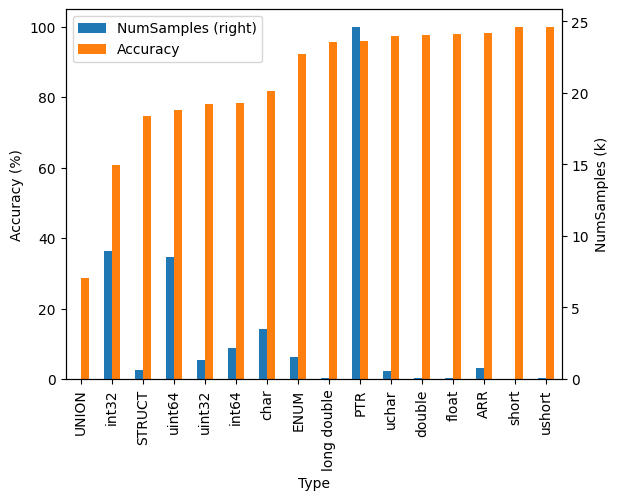

In [14]:
adf = pd.DataFrame(mdf.groupby('TypeSeqL1_Debug').pipe(lambda gb: [(val, len(df)/1000, len(df[df.TypeSeqL1_Debug==df.PredL1])/len(df)*100) for val, df in gb]), columns=['Type', 'NumSamples', 'Accuracy'])\
    .set_index('Type')\
    .sort_values('Accuracy')

ax = adf.plot(kind='bar', secondary_y='NumSamples', ylabel='NumSamples (k)')
ax.set_ylabel('Accuracy (%)')
# adf.plot(kind='bar', y='NumSamples', ax=ax, secondary_y=True)

Text(0, 0.5, 'Accuracy (%)')

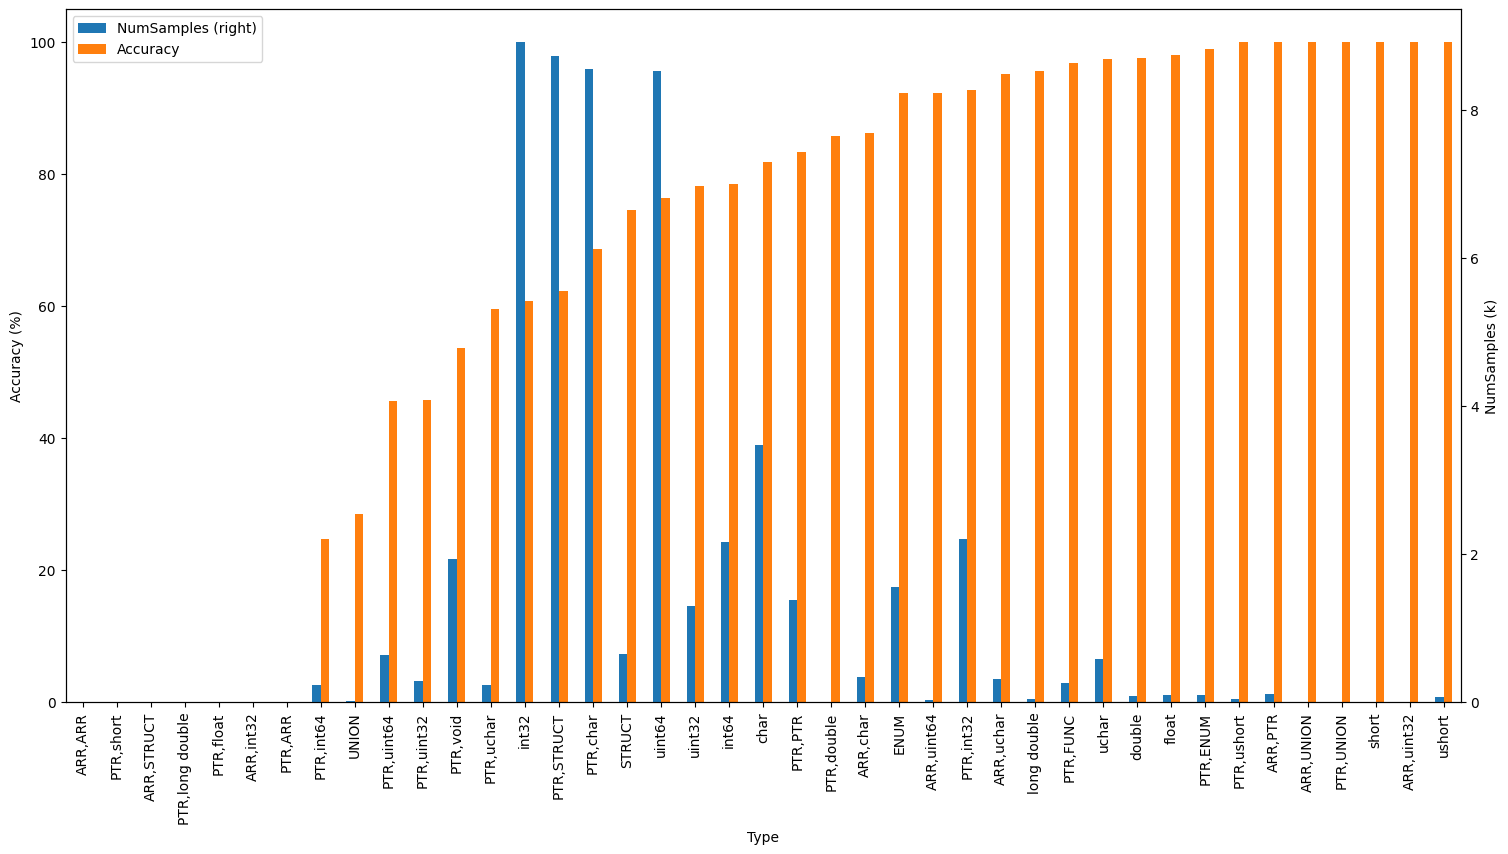

In [15]:
adf = pd.DataFrame(mdf.groupby('TypeSeqL2_Debug').pipe(lambda gb: [(val, len(df)/1000, len(df[df.TypeSeqL2_Debug==df.PredL2])/len(df)*100) for val, df in gb]), columns=['Type', 'NumSamples', 'Accuracy'])\
    .set_index('Type')\
    .sort_values('Accuracy')

ax = adf.plot(kind='bar', secondary_y='NumSamples', ylabel='NumSamples (k)', figsize=(18,9))
ax.set_ylabel('Accuracy (%)')

In [16]:
def calc_accuracy(df):
    return len(df[df.TypeSeq_Debug==df.Pred])/len(df)*100

# calc_accuracy(mdf[mdf.LocType_Debug=='register'])
# calc_accuracy(mdf[mdf.HasDWARF])

mdf.groupby('HasDWARF').pipe(lambda gb: pd.DataFrame([(val, calc_accuracy(df)) for val, df in gb], columns=['HasDWARF', 'Accuracy']))#.plot(kind='bar')

,HasDWARF,Accuracy
0,False,76.807827
1,True,66.116119


In [17]:
xdf = mdf[mdf.TypeSeq_Debug=='PTR,STRUCT']
xdf.groupby('Vartype').count()/len(xdf)*100
xdf[xdf.TypeSeq_Debug!=xdf.Pred].groupby('LocType_Debug').count()
xdf = xdf[xdf.TypeSeq_Debug!=xdf.Pred][['Pred','TypeSeq_Debug','Signature']]
xdf['NumRefs'] = xdf.Signature.apply(lambda s: len(s.strip(',')))
xdf.sort_values('NumRefs')

,Pred,TypeSeq_Debug,Signature,NumRefs
26763,"PTR,char","PTR,STRUCT",44,2
25117,"PTR,void","PTR,STRUCT",77,2
24907,"PTR,void","PTR,STRUCT",77,2
24554,"PTR,void","PTR,STRUCT",77,2
24356,"PTR,void","PTR,STRUCT",77,2
...,...,...,...,...
27482,"PTR,PTR,char","PTR,STRUCT","150,171,192,213,...",160
4533,"PTR,UNION","PTR,STRUCT","107,122,138,154,...",195
26199,"PTR,UNION","PTR,STRUCT","107,122,138,154,...",195
231,"PTR,UNION","PTR,STRUCT","107,122,138,154,...",195


In [18]:
mdf.groupby('TypeSeq_Debug').pipe(lambda gb: pd.DataFrame([(val, calc_accuracy(df), len(df)) for val, df in gb], columns=['TypeSeq_Debug', 'Accuracy', 'Count']))\
    .sort_values('Count',ascending=False)#.plot(kind='bar')

,TypeSeq_Debug,Accuracy,Count
46,int32,60.699865,8916
27,"PTR,STRUCT",62.223749,8733
29,"PTR,char",68.610494,8557
52,uint64,76.418856,8528
43,char,81.873199,3470
32,"PTR,int32",92.688465,2202
47,int64,78.469341,2169
40,"PTR,void",53.687468,1939
13,ENUM,92.253066,1549
51,uint32,78.257517,1297


In [19]:
#mdf.groupby('Pred').count()

In [20]:
# mdf[mdf.Pred.apply(lambda x: 'COMP' in x)]

In [21]:
print(f'Source-level variables make up {len(mdf[(mdf.HasDWARF)])/len(mdf)*100:.2f}% of the dataset')

Source-level variables make up 59.99% of the dataset


In [22]:
mdf_srcvars = mdf.loc[mdf.HasDWARF,:]

In [23]:
acc_corrected_src = len(mdf_srcvars[mdf_srcvars.TypeSeq_Debug==mdf_srcvars.Pred])/len(mdf_srcvars)*100
print(f'Accuracy (corrected) on source-level vars: {acc_corrected_src:.2f}%')

Accuracy (corrected) on source-level vars: 66.12%


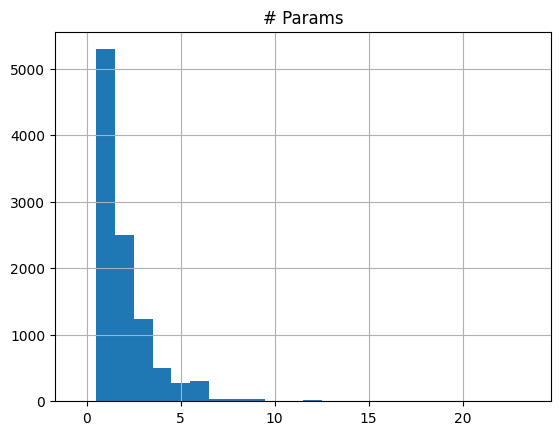

In [24]:
ax = df[(df.Vartype=='p')&(~df.IsReturnType_Debug)].groupby('FunctionStart').count()[['BinaryId']].rename({'BinaryId': '# Params'},axis=1).hist(
    # figsize=(18,5),
    bins=[x-0.5 for x in range(25)],
)
# ax[0][0].set_ylim([0, 500])

In [25]:
dataset_path

PosixPath('/home/cls0027/datasets/coreutils_full_5hops')

In [26]:
# TODO: eval_model(dataset, model, filter_dataset=lambda df: df[df.HasDWARF])
# --> need to calculate the pred_df ONLY ONCE but allow multiple metrics/evals to occur

from typing import Callable

class EvalSubset:
    '''
    Represents a subset of the overall dataset that will be evaluated
    '''
    def __init__(self, name:str, filter_dataset:Callable[[pd.DataFrame], pd.DataFrame]) -> None:
        self.name = name
        self.filter_dataset = filter_dataset


In [27]:
acc_raw = len(mdf[mdf.TypeSeq_Debug==mdf.RawPred])/len(mdf)*100
acc_raw

70.31616367899554

In [28]:
len(df[(df.TypeSeq_Debug!='COMP')&(~df.IsReturnType_Debug)])

52884

In [29]:
# df['Label'] =
df.loc[df.TypeSeq_Debug=='COMP','Label'] = 'COMP'
df.loc[df.IsReturnType_Debug, 'Label'] = 'ReturnType'
df.Label = df.Label.fillna('Local/param')

In [30]:
#df = df.drop('Label', axis=1)

<Axes: xlabel='Label'>

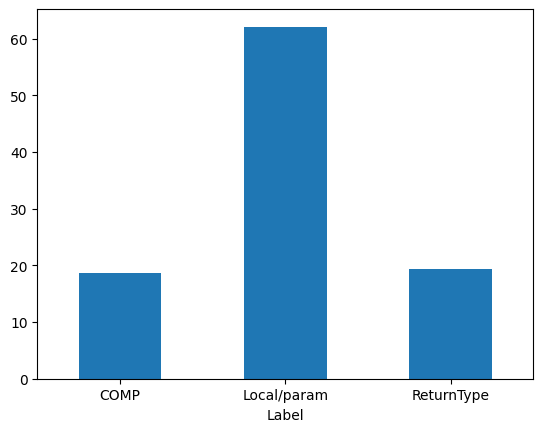

In [31]:
(df.groupby('Label').count().BinaryId/len(df)*100).plot(kind='bar', rot=0)


In [32]:
36992+15872+20

52884

In [33]:
counts = mdf.groupby('TypeSeq_Debug').count().BinaryId
# counts.sort_values()/len(mdf)
# counts.sort_index()

In [34]:
counts = mdf.groupby('TypeSeq_Debug').count()[['BinaryId']]
counts['TypeSeqLen'] = [len(x.split(',')) for x in counts.index]

In [35]:
# counts.sort_values('TSL').BinaryId/len(mdf)*100
order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
counts.loc[order_idx]
(counts.pivot(columns='TypeSeqLen', values='BinaryId')/len(mdf)*100).loc[order_idx]

TypeSeqLen,1,2,3,4
TypeSeq_Debug,,,,
ENUM,2.929052,NaN,NaN,NaN
STRUCT,1.221541,NaN,NaN,NaN
UNION,0.039710,NaN,NaN,NaN
char,6.561531,NaN,NaN,NaN
double,0.160729,NaN,NaN,NaN
float,0.190984,NaN,NaN,NaN
int32,16.859542,NaN,NaN,NaN
int64,4.101430,NaN,NaN,NaN
long double,0.086983,NaN,NaN,NaN


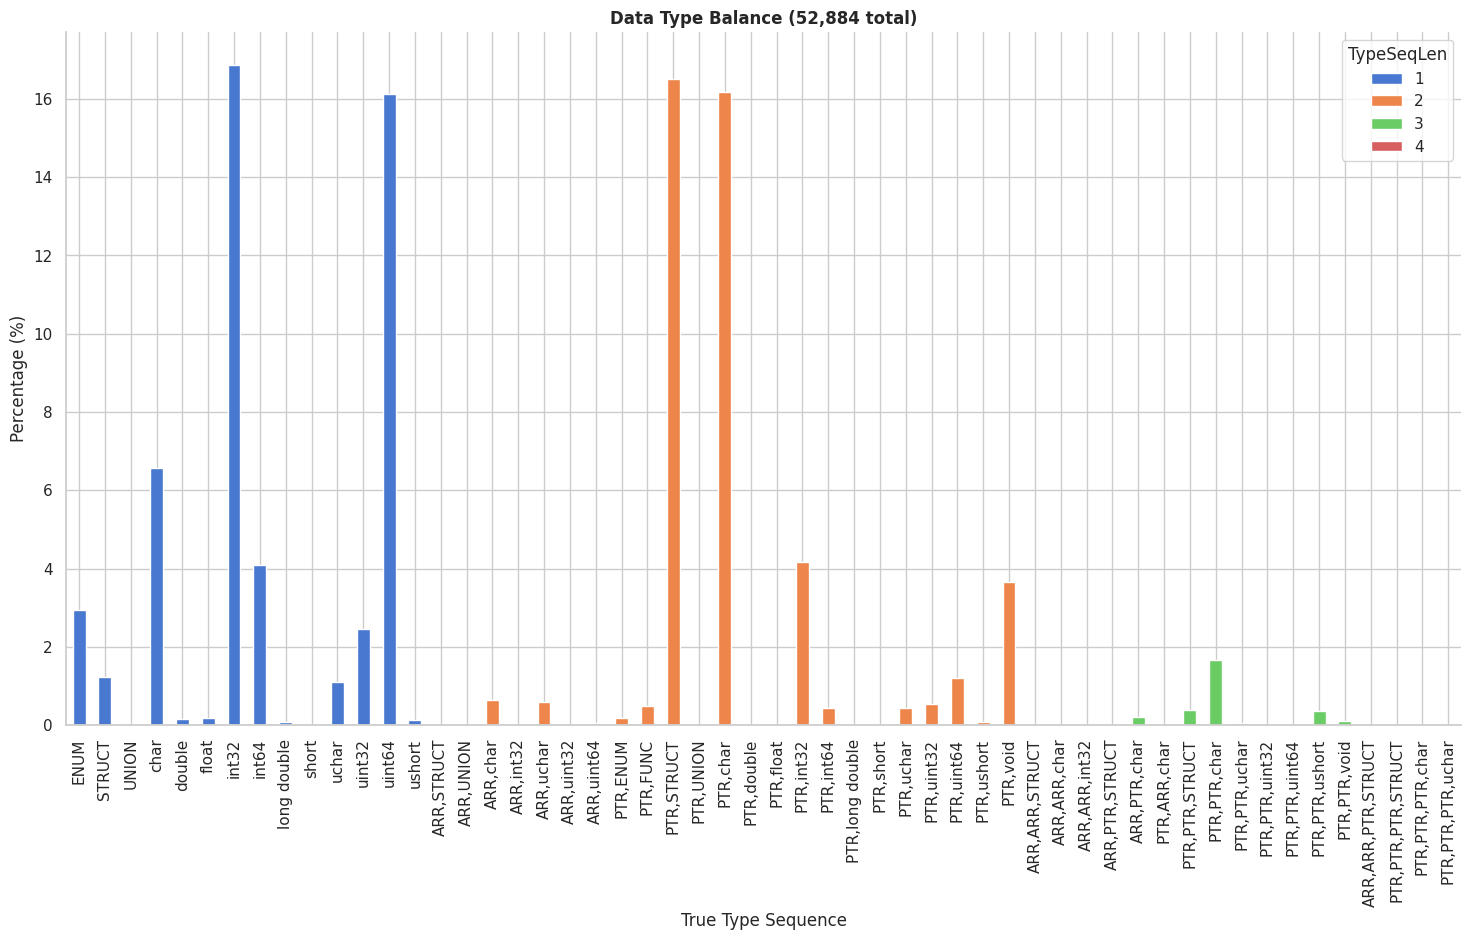

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
bal_df = counts.pivot(columns='TypeSeqLen', values='BinaryId').loc[order_idx]/len(mdf)*100

ax = bal_df.plot(kind='bar', stacked=True, figsize=(18, 9))

ax.set_title(f'Data Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
ax.set_xlabel('True Type Sequence')#, fontweight='bold')
ax.set_ylabel('Percentage (%)')
# ax.set_ylim([0, 0.6])
sns.despine()

# Structure Balance

In [37]:
# mdf['HasSTRUCT'] = mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)
# mdf.groupby('HasSTRUCT').count().BinaryId/len(mdf)*100
sns.set_theme(style='whitegrid', context='talk', palette='muted')# font='Ubuntu')

structs_df = (mdf.groupby(mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)).count()[['BinaryId']]/len(mdf)*100)
structs_df = structs_df.transpose().reset_index(drop=True).rename({False: 'Other', True: 'STRUCT'},axis=1).rename({0: 'Balance'})
structs_df

TypeSeq_Debug,Other,STRUCT
Balance,81.867862,18.132138


(-0.5, 0.85)

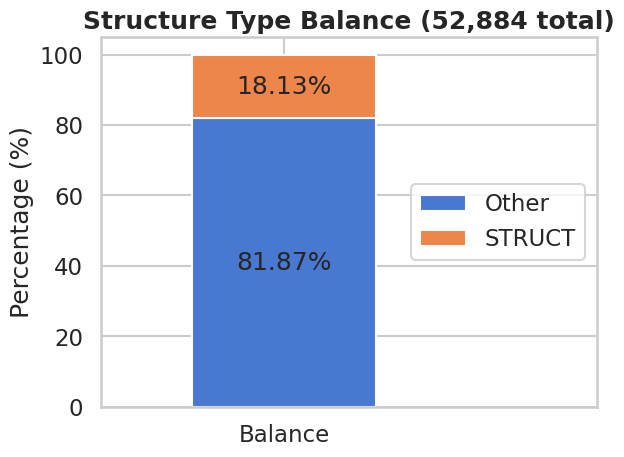

In [38]:
ax = structs_df.plot(kind='bar',
    # figsize=(8,8),
    xlabel='',
    ylabel='Percentage (%)',
    stacked=True,
    rot=0,
)
ax.legend(loc='right')
ax.set_title(f'Structure Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')
ax.set_xlim([-0.5, 0.85])

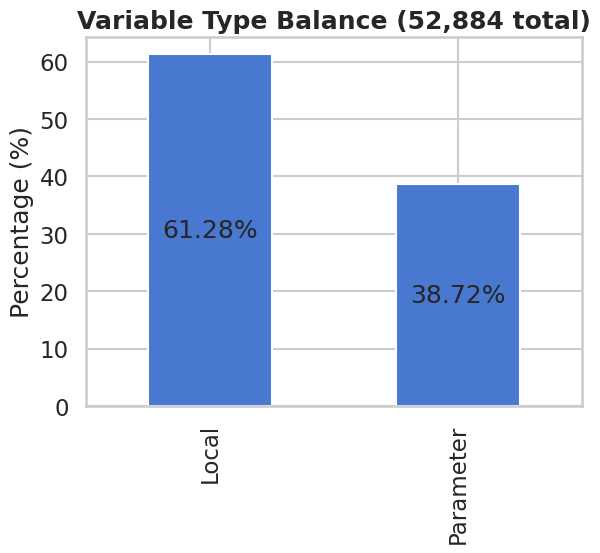

In [39]:
vtype_df = mdf.groupby('Vartype').count()[['BinaryId']]/len(mdf)*100
vtype_df.index = vtype_df.index.map({'l': 'Local', 'p': 'Parameter'})
ax = vtype_df.plot(kind='bar',
    xlabel='',
    ylabel='Percentage (%)',
    legend=False,
)
ax.set_title(f'Variable Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')

In [40]:
import pandas as pd

# pd.read_csv(dataset.root/dataset.raw_file_names[0])
from datatype_recovery.models.dataset import TypeSequenceDataset

ds = TypeSequenceDataset(dataset_path)

In [41]:
exp_runs = pd.read_csv(ds.exp_runs_path)
exp_runs

,RunGid,RunFolder,BinariesCsv,FuncsCsv,ParamsCsv,LocalsCsv
0,0,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...


In [42]:
import pandas as pd
from pathlib import Path
bdf = pd.read_csv(Path.home()/'datasets/coreutils_5hops/raw/binaries.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/cls0027/datasets/coreutils_5hops/raw/binaries.csv'

In [ ]:
bdf[bdf.BinaryId==1010]

In [ ]:
ldf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/locals.csv')
ldf[ldf.FunctionStart==0x10154b]

In [ ]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154
!echo ""
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154

# TODO: fix this logic - split on '-' and THEN match name.log

In [ ]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/

fdf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/19.printenv/functions.csv')
fdf[fdf.FunctionName_DWARF.isna()]
len(fdf.loc[fdf.FunctionName_DWARF.isna(),:])
len(fdf)
fdf.loc[fdf.FunctionName_DWARF.isna(),:]